In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [7]:
imgsize=256
batchsize=32
channels=3
epochs=50

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(imgsize,imgsize),
    batch_size=batchsize
    
)

Found 2152 files belonging to 3 classes.


In [6]:
classnm=dataset.class_names
classnm

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# 80% Training 
# 10% Validation
# 10% Testing

In [26]:
def getdatasetpartitions(ds,trainsplit=0.8,valsplit=0.1,testsplit=0.1,shuffle=True,shufflesize=10000):
    dssize=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shufflesize,seed=12)
    
    trainsize=int(trainsplit*dssize)
    valsize=int(valsplit*dssize)
    
    trainds=ds.take(trainsize)
    
    valds=ds.skip(trainsize).take(valsize)
    testds=ds.skip(trainsize).skip(valsize)
    
    return trainds,valds,testds

In [27]:
trainds,valds,testds=getdatasetpartitions(dataset)

In [28]:
len(trainds)

54

In [29]:
len(valds)

6

In [30]:
len(testds)

8

In [32]:
trainds=trainds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valds=valds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testds=testds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
resize_rescale_layer=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imgsize,imgsize),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [39]:
data_augmentation_layer=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [53]:
inshape=(batchsize,imgsize,imgsize,channels)
nclasses=3
model=models.Sequential([
    resize_rescale_layer,
    #data_augmentation_layer,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=inshape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(nclasses,activation='softmax'),
])

model.build(input_shape=inshape)

In [54]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (32, 246016)             

In [55]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [57]:
history=model.fit(
    trainds,
    epochs=5,
    batch_size=batchsize,
    verbose=1,
    validation_data=valds
)

Epoch 1/5
54/54 [==============================] - 129s 2s/step - loss: 0.3428 - accuracy: 0.8883 - val_loss: 0.1352 - val_accuracy: 0.9635
Epoch 2/5
54/54 [==============================] - 120s 2s/step - loss: 0.1283 - accuracy: 0.9595 - val_loss: 0.0389 - val_accuracy: 0.9948
Epoch 3/5
54/54 [==============================] - 118s 2s/step - loss: 0.0630 - accuracy: 0.9797 - val_loss: 0.0831 - val_accuracy: 0.9740
Epoch 4/5
54/54 [==============================] - 119s 2s/step - loss: 0.0487 - accuracy: 0.9850 - val_loss: 0.0314 - val_accuracy: 0.9948
Epoch 5/5
54/54 [==============================] - 120s 2s/step - loss: 0.0183 - accuracy: 0.9948 - val_loss: 0.0099 - val_accuracy: 1.0000


In [59]:
scores=model.evaluate(testds)

8/8 [==============================] - 4s 467ms/step - loss: 0.0254 - accuracy: 0.9922


In [60]:
scores

[0.025435809046030045, 0.9921875]

In [61]:
history

In [62]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [63]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [64]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

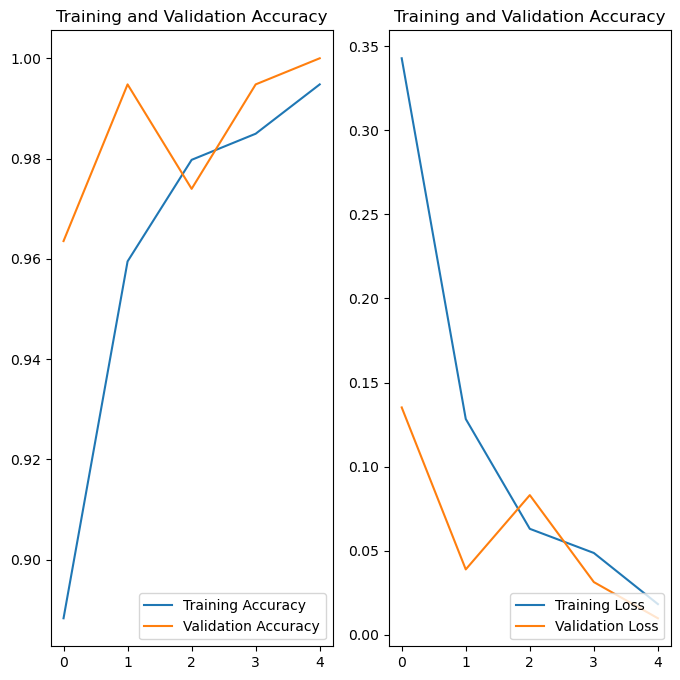

In [71]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(5),acc,label='Training Accuracy')
plt.plot(range(5),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(5),loss,label='Training Loss')
plt.plot(range(5),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

First image to predict
Actual label: Potato___Late_blight
1/1 [==============================] - 1s 507ms/step
Predicted label: Potato___Late_blight


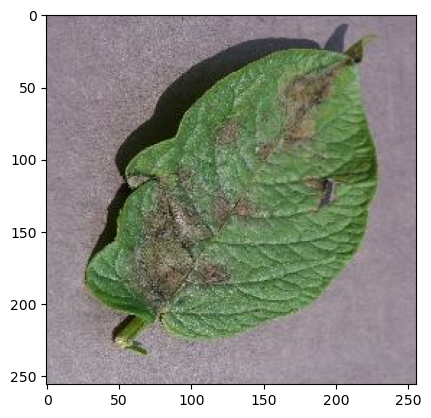

In [80]:
import numpy as np
for img_batch, labels_batch in testds.take(1):
    
    first_img=img_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_img)
    print("Actual label:",classnm[first_label])
    
    batch_prediction=model.predict(img_batch)
    print("Predicted label:",classnm[np.argmax(batch_prediction[0])])

In [90]:
model_version=1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets
